In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd
import math
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression

In [3]:
from sensitivity import dml_sensitivity_bounds, dml_tvalue
from sensitivity import sensitivity_bounds, tvalue, sensitivity_contours
from debiased import DebiasedMoment
from econml.dml import LinearDML

In [4]:
from automl import reg_fn_gen, rr_fn_gen, model_y_fn_gen

In [5]:
# The moment function, whose average we want to estimate: E[m(X; g)]
def moment_fn(x, test_fn):
    epsilon = 0.01
    t1 = np.hstack([x[:, [0]] + epsilon, x[:, 1:]])
    t0 = np.hstack([x[:, [0]] - epsilon, x[:, 1:]])
    return (test_fn(t1) - test_fn(t0)) / (2*epsilon)

In [6]:
# Data loading and manipulation

# for semi-synthetic data generation
def true_f(X):
    y = (-.7 - .4 * scipy.special.expit(3 * (1 - 2*(X[:, 1] - 10.5)))) * X[:, 0]
    y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
    return y

# def true_f(X):
#     y = -.7 * X[:, 0]
#     y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
#     return y

def get_data(q=None, synthetic=False, region=True, state=False, region_ids=None, random_seed=123):
    df = pd.read_csv('./BHP2017/data_BHP2_with_region.csv')
    # Throw away low prices and low income due to sample quality as in Chetverikov
    df = df[df["log_p"] > math.log(1.2)]
    df = df[df["log_y"] > math.log(15000)]
    if not ((q==4) | (q==5)): # all data in first three brackets
        df = df[df["log_y"] >= math.log(42500) - .5]
        df = df[df["log_y"] <= math.log(72500) + .5]
    if q == 1:
        df = df[df["log_y"] >= math.log(42500) - .5]
        df = df[df["log_y"] <= math.log(42500) + .5]
    if q == 2:
        df = df[df["log_y"] >= math.log(57500) - .5]
        df = df[df["log_y"] <= math.log(57500) + .5]
    if q == 3:
        df = df[df["log_y"] >= math.log(72500) - .5]
        df = df[df["log_y"] <= math.log(72500) + .5]
    if q == 4:
        df = df[df["log_y"] >= 11.6]
    if region_ids is not None: # Sub-select particular regions
        df = df[np.any([df['region'] == r for r in region_ids], axis=0)]
    Xdf = df.iloc[:, 1:] # Covariates
    X_nostatedum = Xdf.drop(["distance_oil1000", "share"], axis=1).values 
    if state: # whether to control for state id; almost no price variation left
        state_dum = pd.get_dummies(Xdf['state_fips'], prefix="state", drop_first=True)
        Xdf = pd.concat([Xdf, state_dum], axis = 1)
    if region: # whether to control for regrion id
        region_dum = pd.get_dummies(Xdf['region'], prefix="region", drop_first=True)
        Xdf = pd.concat([Xdf, region_dum], axis = 1)
    # Drop instrument and things we've one-hot encoded and weird share variable
    Xdf = Xdf.drop(["distance_oil1000", "state_fips", "share", 'region'], axis=1)
    column_names = Xdf.columns
    X = Xdf.values # to numpy array
    y = df['log_q'].values # outcome to numpy array
    if synthetic: # impute synthetic outcome based on known relationship
        y = true_f(X) + np.random.normal(0, .2, size=X[:, 0].shape)
        print(np.mean(moment_fn(X, true_f)))
    
    # Create state-block-wise and stratified by region folds for cross validation and cross fitting
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_seed)
    splits = list(cv.split(df, y=df['region'], groups=df['state_fips']))
    return X, y, [0, 1, 6, 7, 8], splits, column_names

In [7]:
# global result dictionaries and global parameters
ests = {}
res = {}
res_d = {}
q_grid = np.arange(1, 6)
synthetic = False # use synthetic outcome
verbose = 0
region = True # control for region

# Ablation study for riesz variance explained

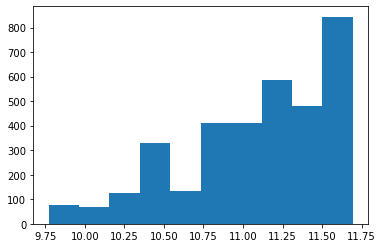

In [8]:
# log-income distribution
X, y, num_cols, splits, column_names = get_data(5, region=region, random_seed=124)
plt.hist(X[:, 1])
plt.show()

In [9]:
ablation_groups = [('log_y', [1]), ('urban', [2, 3, 4, 5]), ('log_driver', [6]),
                   ('log_hhr_age', [7]), ('log_hhsize', [8]),
                   ('popdensity', [9, 10, 11, 12, 13, 14, 15]),
                   ('publictransit_d', [16]), ('total_wrkr', [17])]
if region:
    ablation_groups += [('region', [18, 19, 20, 21, 22, 23, 24, 25])]

In [10]:
from ablation import ablation_multiseed, plr_ablation_multiseed
get_data_fn = lambda seed: get_data(5, region=region, random_seed=seed)

In [ ]:
plr_etasq, plr_Cy, plr_dtheta, plr_rho = plr_ablation_multiseed(ablation_groups, moment_fn,
                                                                get_data_fn, model_y_fn_gen, model_y_fn_gen, verbose)

In [12]:
for key, value in plr_etasq.items():
    print(key, f'etasq={value[0]:.4f} ({value[1]:.4f}), Cy={plr_Cy[key][0]:.4f} ({plr_Cy[key][1]:.4f}), ',
          f'dtheta={plr_dtheta[key][0]:.4f} ({plr_dtheta[key][1]:.4f}), ',
          f'rho={plr_rho[key][0]:.4f} ({plr_rho[key][1]:.4f})')

log_y etasq=0.0019 (0.0028), Cy=0.0676 (0.0094)
urban etasq=-0.0029 (0.0026), Cy=0.0085 (0.0063)
log_driver etasq=0.0011 (0.0006), Cy=0.0160 (0.0049)
log_hhr_age etasq=0.0008 (0.0007), Cy=-0.0003 (0.0016)
log_hhsize etasq=0.0004 (0.0004), Cy=-0.0006 (0.0013)
popdensity etasq=0.0001 (0.0013), Cy=0.0049 (0.0042)
publictransit_d etasq=-0.0171 (0.0181), Cy=-0.0026 (0.0027)
total_wrkr etasq=-0.0002 (0.0003), Cy=0.0110 (0.0037)
region etasq=0.4225 (0.1084), Cy=-0.0028 (0.0052)


In [ ]:
np_etasq, np_Cy, np_dtheta, np_rho = ablation_multiseed(ablation_groups, moment_fn,
                                                        get_data_fn, reg_fn_gen, rr_fn_gen, verbose)

In [14]:
for key, value in np_etasq.items():
    print(key, f'etasq={value[0]:.4f} ({value[1]:.4f}), Cy={np_Cy[key][0]:.4f} ({np_Cy[key][1]:.4f}), ',
          f'dtheta={np_dtheta[key][0]:.4f} ({np_dtheta[key][1]:.4f}), ',
          f'rho={np_rho[key][0]:.4f} ({np_rho[key][1]:.4f})')

log_y etasq=-0.0021 (0.0075), Cy=0.0690 (0.0096)
urban etasq=-0.0030 (0.0028), Cy=0.0115 (0.0074)
log_driver etasq=-0.0027 (0.0040), Cy=0.0169 (0.0051)
log_hhr_age etasq=-0.0056 (0.0089), Cy=-0.0008 (0.0010)
log_hhsize etasq=-0.0058 (0.0080), Cy=-0.0007 (0.0013)
popdensity etasq=-0.0002 (0.0021), Cy=0.0038 (0.0044)
publictransit_d etasq=-0.0113 (0.0501), Cy=-0.0020 (0.0022)
total_wrkr etasq=-0.0026 (0.0036), Cy=0.0107 (0.0037)
region etasq=0.5433 (0.1677), Cy=-0.0015 (0.0034)


# Main analysis

In [15]:
# General pipeline for all types of estimators to generate the estimation result we want
def generic_pipeline(estimator, q_grid, name, n_seeds=5):
    ests = {}
    res = {}
    for q in q_grid:
        print(f'q={q}')
        ests[f'q={q}'] = []
        estimate_list = []
        for random_seed in np.arange(123, 123 + n_seeds):
            X, y, num_cols, splits, column_names = get_data(q, region=region, synthetic=synthetic, random_seed=random_seed)
            estimates, model = estimator(X, y, num_cols, splits)
            print(estimates)
            estimate_list.append(estimates)
            ests[f'q={q}'].append(model)
        estimate_list = np.array(estimate_list)
        res[f'q={q}'] = {}
        res[f'q={q}'][f'{name}'] = {}
        res[f'q={q}'][f'{name}']['point'] = np.mean(estimate_list[:, 0])
        if estimate_list.shape[1] > 2:
            res[f'q={q}'][f'{name}']['stderr'] = np.sqrt(np.mean(estimate_list[:, 1]**2) 
                                                         + np.var(estimate_list[:, 0]))
        res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
    return pd.concat(res), ests

In [16]:
# Transforming results to a nicely printable dataframe where each cell
# contains point (stderr) [ci_lower, ci_upper]
def transform_res_to_df(res, q_grid, alpha=None):
    res_f = res.reset_index()
    res_d = {}
    for q in q_grid:
        key = 'all <= 11.6' if q==0 else ('all' if q==5 else f'q={q}')
        res_d[key] = {}
        for method in np.unique(res_f['level_1'].values):
            p = res.loc[(f'q={q}', method), 'point']
            if alpha is not None:
                s = res.loc[(f'q={q}', method), 'stderr']
                error = scipy.stats.norm.ppf(1 - alpha) * s
                l, u = p - error, p + error
                res_d[key][method] = f"{p:.2f} ({s:.2f}) [{l:.2f}, {u:.2f}]"
            else:
                res_d[key][method] = f"{p:.2f}"
        
    return pd.DataFrame(res_d)

In [17]:
if synthetic:
    def oracle_estimator(X, y, num_cols, splits):
        return (np.mean(moment_fn(X, true_f)),), None
    res['true'], _ = generic_pipeline(oracle_estimator, q_grid, 'true', n_seeds=1)
    res_d['true'] = transform_res_to_df(res['true'], q_grid)
    display(res_d['true'])

# Non-Linear RR Analysis

In [18]:
# fully non-parametric average derivative estimation
def nonlinrr(X, y, num_cols, splits):
    get_reisz_fn = rr_fn_gen(moment_fn, num_cols, cv=splits, verbose=verbose)
    get_reg_fn = reg_fn_gen(num_cols, cv=splits, verbose=verbose)
    est = DebiasedMoment(moment_fn=moment_fn,
                         get_reisz_fn=get_reisz_fn,
                         get_reg_fn=get_reg_fn,
                         n_splits=splits)
    est.fit(X, y)
    return est.avg_moment(alpha=.1), est

In [19]:
res['rr'], ests['rr'] = generic_pipeline(nonlinrr, q_grid, 'dr')

q=1
(-0.39335949163272055, 0.4515370276947403, -1.1364959827693282, 0.3497769995038871)
(-0.6996071161492304, 0.3161997723006776, -1.2200064962075516, -0.17920773609090923)
(-0.8973634244235447, 0.35351211159018286, -1.4791711922662825, -0.31555565658080675)
(-0.6484359805809444, 0.4108239854422913, -1.324567230713407, 0.02769526955151813)
(-0.5549776067735978, 0.340918144551573, -1.1160583114951916, 0.006103097947996128)
q=2
(-0.5553723833214458, 0.24511138033338253, -0.958712885528267, -0.15203188111462462)
(-0.11890612688468216, 0.5299468880743615, -0.9909547591763743, 0.75314250540701)
(-0.3509079404746248, 0.37456126983677235, -0.9672633723509673, 0.26544749140171764)
(-0.8862226036643418, 0.27991653092308616, -1.346836362213407, -0.4256088451152766)
(-0.8600109261386052, 0.8080443301493352, -2.189679934099471, 0.46965808182226076)
q=3
(-1.0084078031360129, 0.39241971646569507, -1.6541980041922453, -0.36261760207978044)
(-0.7539988920353997, 0.3058224943587671, -1.2572793385384788

In [20]:
res_d['rr'] = transform_res_to_df(res['rr'], q_grid, alpha=0.05)
res_d['rr']

,q=1,q=2,q=3,q=4,all
dr,"-0.64 (0.41) [-1.32, 0.04]","-0.55 (0.57) [-1.50, 0.39]","-0.81 (0.39) [-1.45, -0.16]","-1.44 (0.69) [-2.57, -0.31]","-0.76 (0.36) [-1.35, -0.17]"


### Sensitivity Analysis Example

In [21]:
q = 5
est = ests['rr'][f'q={q}'][0] # look at one of the cv split seeds
X, y, num_cols, splits, column_names = get_data(q)

In [22]:
p, s, l, u = est.avg_moment(alpha=.1)
print(f'{p:.2f}, ({s:.2f}) [{l:.2f}, {u:.2f}]')

-1.11, (0.27) [-1.55, -0.67]


In [23]:
l, u = sensitivity_bounds([est], .03, .03, alpha=None)
print(f'[{l:.2f}, {u:.2f}]')

[-1.53, -0.68]


In [24]:
l, u = sensitivity_bounds([est], .03, .03, alpha=.05)
print(f'[{l:.2f}, {u:.2f}]')

[-1.97, -0.25]


In [25]:
print(f'{tvalue([est], value=0, leq=False, alpha=None):.3f}')

0.077


In [26]:
print(f'{tvalue([est], value=0, leq=False, alpha=.05):.3f}')

0.047


In [27]:
eta_asq, eta_ysq, lower, upper = sensitivity_contours([est], 0.15, 0.15, alpha=0.05)

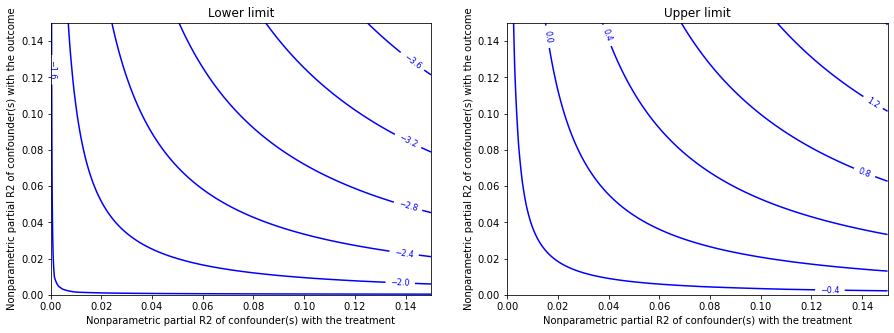

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
contours = plt.contour(eta_asq, eta_ysq, lower, 6, linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Lower limit')
plt.xlabel('Nonparametric partial R2 of confounder(s) with the treatment')
plt.ylabel('Nonparametric partial R2 of confounder(s) with the outcome')

plt.subplot(1, 2, 2)
contours = plt.contour(eta_asq, eta_ysq, upper, 6, linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Upper limit')
plt.xlabel('Nonparametric partial R2 of confounder(s) with the treatment')
plt.ylabel('Nonparametric partial R2 of confounder(s) with the outcome')

plt.show()

### Diagnostics examples

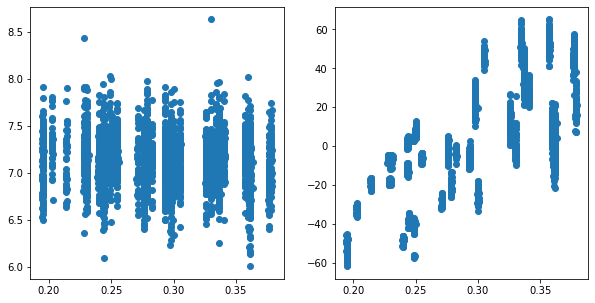

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], est.reg_pred_)
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], est.reisz_pred_)
plt.show()

# OLS analysis

In [30]:
# fully linear OLS-based average derivative estimation
def ols_estimator(X, y, num_cols, splits):
    est = OLS(y, np.hstack([np.ones((X.shape[0], 1)), X])).fit(cov_type='HC3')
    return (est.params[1], est.bse[1], *est.conf_int(alpha=.1)[1]), est

In [31]:
res['ols'], ests['ols'] = generic_pipeline(ols_estimator, q_grid, 'ols', n_seeds=1)

q=1
(-0.4238896667189258, 0.5347189961526235, -1.303424146940419, 0.45564481350256736)
q=2
(-0.571997959151515, 0.4366961545825266, -1.2902992128923447, 0.14630329458931468)
q=3
(-0.5907429522075469, 0.47775522819372324, -1.3765803720970209, 0.19509446768192695)
q=4
(-1.5415722036035109, 0.739758259711174, -2.7583662601567447, -0.3247781470502771)
q=5
(-0.6188991175589147, 0.3619256648493131, -1.2142138600731303, -0.023584375044699124)


In [32]:
res_d['ols'] = transform_res_to_df(res['ols'], q_grid, alpha=0.05)
res_d['ols']

,q=1,q=2,q=3,q=4,all
ols,"-0.42 (0.53) [-1.30, 0.46]","-0.57 (0.44) [-1.29, 0.15]","-0.59 (0.48) [-1.38, 0.20]","-1.54 (0.74) [-2.76, -0.32]","-0.62 (0.36) [-1.21, -0.02]"


# Lasso Analysis

In [33]:
# fully linear Lasso-based average derivative estimation
def lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    est = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                    ('lasso', LassoCV(cv=splits))])
    est.fit(X, y)
    p = np.mean(est.predict(np.hstack([np.ones((X.shape[0], 1)), X[:, 1:]])) 
            - est.predict(np.hstack([np.zeros((X.shape[0], 1)), X[:, 1:]])))
    return (p,), est

In [34]:
res['lasso'], ests['lasso'] = generic_pipeline(lasso_estimator, q_grid, 'lasso')

q=1
(-0.850194840897473,)
(-0.8656561453025441,)
(-0.8656561453025441,)
(-0.8447892287343629,)
(-0.8656561453025441,)
q=2
(-0.5518674868195881,)
(-0.5592422725556091,)
(-0.5532939644598079,)
(-0.5572551471675227,)
(-0.5603815202912215,)
q=3
(-0.5412302445377849,)
(-0.5123310354374929,)
(-0.5817794147332956,)
(-0.5412302445377849,)
(-0.5560417870542349,)
q=4
(-0.8292944822023104,)
(0.0,)
(-0.8292944822023104,)
(0.0,)
(-1.0744311330403784,)
q=5
(-0.574722943895406,)
(-0.4415625139347162,)
(-0.6160404418962586,)
(-0.41770271064868103,)
(-0.4512188550986626,)


In [35]:
res_d['lasso'] = transform_res_to_df(res['lasso'], q_grid)
res_d['lasso']

,q=1,q=2,q=3,q=4,all
lasso,-0.86,-0.56,-0.55,-0.55,-0.50


# DML Analysis

In [36]:
# fully linear debiased Lasso-based average derivative estimation, with doubleML
def dml_lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_reg = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                          ('lasso', LassoCV(cv=splits))])
    model_y = clone(model_reg).fit(X[:, 1:], y)
    model_y = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_y.named_steps['lasso'].alpha_))])
    model_t = clone(model_reg).fit(X[:, 1:], X[:, 0])
    model_t = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_t.named_steps['lasso'].alpha_))])
    est = LinearDML(model_y=model_y,
                    model_t=model_t,
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [37]:
res['dml_lasso'], ests['dml_lasso'] = generic_pipeline(dml_lasso_estimator, q_grid, 'dml_lasso')

q=1
(-0.7083909447839296, 0.37647699829485465, -1.3276405008930248, -0.08914138867483468)
(-0.5112399077455708, 0.38167599044251627, -1.1390410449452393, 0.11656122945409753)
(-0.608095009796004, 0.39399258366011397, -1.256155140021324, 0.03996512042931588)
(-0.5748227554900788, 0.3581742172776422, -1.1639669158597135, 0.014321404879555688)
(-0.33651833932765396, 0.3738984515318007, -0.9515265634412758, 0.2784898847859676)
q=2
(-0.7806731790607957, 0.30566235905252054, -1.2834430189708774, -0.2779033391507141)
(-0.5034273917619266, 0.31639395062948944, -1.0238491290003475, 0.016994345476494144)
(-0.5213064320980262, 0.33363716004347255, -1.0700907248813212, 0.027477860685268474)
(-0.8656674673200735, 0.30437959800174436, -1.366327353063274, -0.3650075815768732)
(-0.5396644801356254, 0.2665474732566022, -0.9780960582764983, -0.10123290199475271)
q=3
(-0.6815066579694237, 0.28957088705142325, -1.1578083817955125, -0.20520493414333502)
(-0.5624627749571044, 0.3349193675208561, -1.11335611

In [38]:
res_d['dml_lasso'] = transform_res_to_df(res['dml_lasso'], q_grid, alpha=.05)
res_d['dml_lasso']

,q=1,q=2,q=3,q=4,all
dml_lasso,"-0.55 (0.40) [-1.20, 0.10]","-0.64 (0.34) [-1.20, -0.08]","-0.74 (0.39) [-1.39, -0.10]","-1.76 (0.56) [-2.68, -0.85]","-0.82 (0.27) [-1.26, -0.38]"


# DML with Non-Linear Residualizers

In [39]:
# partially linear average derivative estimation, with doubleML
def dml_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_y = reg_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], y)
    model_t = reg_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], X[:, 0])
    est = LinearDML(model_y=model_y(),
                    model_t=model_t(),
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [40]:
res['dml'], ests['dml'] = generic_pipeline(dml_estimator, q_grid, 'dml')

q=1
(-0.453154175710313, 0.37934319909583825, -1.0771182126024772, 0.17080986118185093)
(-0.26643055979664715, 0.3805224563645251, -0.8923343022843198, 0.3594731826910253)
(-0.6354917224203085, 0.38959678531893993, -1.2763214078008012, 0.005337962960183962)
(-0.5865784879943672, 0.3513257023014943, -1.1644578436662534, -0.008699132322481096)
(-0.369277290213017, 0.37317720696858164, -0.9830991725909088, 0.24454459216487473)
q=2
(-0.7214254600778969, 0.30469726049673423, -1.2226078541281278, -0.22024306602766608)
(-0.4935286023354814, 0.30461193299741574, -0.9945706451389797, 0.007513440468016663)
(-0.534076915821805, 0.33367866961449705, -1.0829294857735527, 0.014775654129942417)
(-0.8695806586470195, 0.30378148748513895, -1.3692567401376636, -0.3699045771563754)
(-0.5367052009611407, 0.2609352638041786, -0.9659055160289832, -0.10750488589329837)
q=3
(-0.6942226179479276, 0.2895695347721184, -1.1705221174724971, -0.21792311842335826)
(-0.5585727076909797, 0.3453168683947733, -1.1265684

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+02, tolerance: 1.368e-01


(-0.7916917247589723, 0.25941879800130846, -1.2183976755508161, -0.3649857739671288)
(-0.6871233091880075, 0.2597086098731407, -1.114305958088368, -0.25994066028764706)
(-0.6832064990234141, 0.21415509935867147, -1.0354602909336779, -0.33095270711315045)


In [41]:
res_d['dml'] = transform_res_to_df(res['dml'], q_grid, alpha=.05)
res_d['dml']

,q=1,q=2,q=3,q=4,all
dml,"-0.46 (0.40) [-1.12, 0.19]","-0.63 (0.33) [-1.18, -0.08]","-0.75 (0.38) [-1.38, -0.13]","-1.79 (0.52) [-2.65, -0.93]","-0.70 (0.26) [-1.12, -0.28]"


# Put all results together

In [42]:
res_d_all = pd.concat(res_d)

In [43]:
heading_properties = [('font-size', '11px')]

cell_properties = [('font-size', '11px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

res_d_all.style.set_table_styles(dfstyle)

,,q=1,q=2,q=3,q=4,all
rr,dr,"-0.64 (0.41) [-1.32, 0.04]","-0.55 (0.57) [-1.50, 0.39]","-0.81 (0.39) [-1.45, -0.16]","-1.44 (0.69) [-2.57, -0.31]","-0.76 (0.36) [-1.35, -0.17]"
ols,ols,"-0.42 (0.53) [-1.30, 0.46]","-0.57 (0.44) [-1.29, 0.15]","-0.59 (0.48) [-1.38, 0.20]","-1.54 (0.74) [-2.76, -0.32]","-0.62 (0.36) [-1.21, -0.02]"
lasso,lasso,-0.86,-0.56,-0.55,-0.55,-0.50
dml_lasso,dml_lasso,"-0.55 (0.40) [-1.20, 0.10]","-0.64 (0.34) [-1.20, -0.08]","-0.74 (0.39) [-1.39, -0.10]","-1.76 (0.56) [-2.68, -0.85]","-0.82 (0.27) [-1.26, -0.38]"
dml,dml,"-0.46 (0.40) [-1.12, 0.19]","-0.63 (0.33) [-1.18, -0.08]","-0.75 (0.38) [-1.38, -0.13]","-1.79 (0.52) [-2.65, -0.93]","-0.70 (0.26) [-1.12, -0.28]"


# Paper tables

In [44]:
table = {}
table['point'] = '{:.3f} ({:.3f})'.format(res['rr'].loc[(f'q={5}', 'dr'), 'point'],
                                          res['rr'].loc[(f'q={5}', 'dr'), 'stderr'])

est_list = ests['rr'][f'q={5}']
table['Bounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .03, .03, alpha=None))
table['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .03, .03, alpha=.05))
table['RV(v=-1.5)'] = '{:.3f}'.format(tvalue(est_list, value=-1.5, leq=True, alpha=None))
table['RV(v=-1.5,a=.05)'] = '{:.3f}'.format(tvalue(est_list, value=-1.5, leq=True, alpha=.05))
table['RV(v=0)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=False, alpha=None))
table['RV(v=0,a=.05)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=False, alpha=.05))

In [45]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml_lasso'].loc[(f'q={5}', 'dml_lasso'), 'point'],
                                          res['dml_lasso'].loc[(f'q={5}', 'dml_lasso'), 'stderr'])

est_list = ests['dml_lasso'][f'q={5}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=.05))
table2['RV(v=-1.5)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=None))
table2['RV(v=-1.5,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=.05))

In [46]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml'].loc[(f'q={5}', 'dml'), 'point'],
                                          res['dml'].loc[(f'q={5}', 'dml'), 'stderr'])

est_list = ests['dml'][f'q={5}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=.05))
table2['RV(v=-1.5)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=None))
table2['RV(v=-1.5,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=.05))

In [47]:
tabledf = pd.DataFrame({'Non-parametric': table, 'Partially linear': table2}).T[['point', 'Bounds', 'CIBounds',
                                                                                 'RV(v=-1.5)', 'RV(v=-1.5,a=.05)',
                                                                                 'RV(v=0)', 'RV(v=0,a=.05)']]
tabledf

,point,Bounds,CIBounds,RV(v=-1.5),"RV(v=-1.5,a=.05)",RV(v=0),"RV(v=0,a=.05)"
Non-parametric,-0.761 (0.360),"[-1.232, -0.291]","[-1.827, 0.314]",0.047,0.010,0.049,0.011
Partially linear,-0.701 (0.257),"[-1.147, -0.255]","[-1.574, 0.172]",0.054,0.026,0.047,0.019


In [48]:
print(tabledf.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &           point &            Bounds &         CIBounds & RV(v=-1.5) & RV(v=-1.5,a=.05) & RV(v=0) & RV(v=0,a=.05) \\
\midrule
Non-parametric   &  -0.761 (0.360) &  [-1.232, -0.291] &  [-1.827, 0.314] &      0.047 &            0.010 &   0.049 &         0.011 \\
Partially linear &  -0.701 (0.257) &  [-1.147, -0.255] &  [-1.574, 0.172] &      0.054 &            0.026 &   0.047 &         0.019 \\
\bottomrule
\end{tabular}



# Paper income quantile plots

### Based on separate nuisance fitting per sub-group

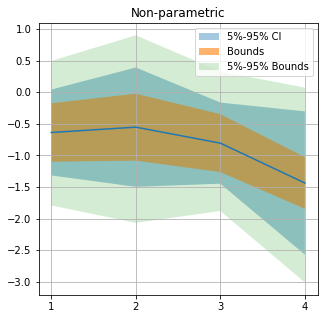

In [49]:
qgr = np.arange(1, 5)

point = [res['rr'].loc[(f'q={q}', 'dr'), 'point'] for q in qgr]
lower = [res['rr'].loc[(f'q={q}', 'dr'), 'point'] - 1.645*res['rr'].loc[(f'q={q}', 'dr'), 'stderr']
         for q in qgr]
upper = [res['rr'].loc[(f'q={q}', 'dr'), 'point'] + 1.645*res['rr'].loc[(f'q={q}', 'dr'), 'stderr']
         for q in qgr]
sens_band = [sensitivity_bounds(ests['rr'][f'q={q}'], .03, .03, alpha=None) for q in qgr]
sens_band_unc = [sensitivity_bounds(ests['rr'][f'q={q}'], .03, .03, alpha=.05) for q in qgr]

# save csv to pass to R
tempdf = pd.DataFrame({"point": point})
tempdf = pd.concat([tempdf, pd.DataFrame(sens_band)], axis = 1)
tempdf = pd.concat([tempdf, pd.DataFrame(sens_band_unc)], axis = 1)
tempdf.to_csv("gas_quart_npm.csv")

if synthetic:
    true_moment = [res['true'].loc[(f'q={q}', 'true'), 'point'] for q in qgr]

plt.figure(figsize=(5, 5))
plt.plot(qgr, point)
plt.fill_between(qgr, lower, upper, alpha=.4, label='5%-95% CI')
plt.fill_between(qgr, *list(zip(*sens_band)), alpha=.6, label='Bounds')
plt.fill_between(qgr, *list(zip(*sens_band_unc)), alpha=.2, label='5%-95% Bounds')
if synthetic:
    plt.plot(qgr, true_moment, label='true')
plt.xticks(qgr)
plt.title('Non-parametric')
plt.legend()
plt.grid()
plt.savefig('nonparam_quantile_avgder.pdf', dpi=600)

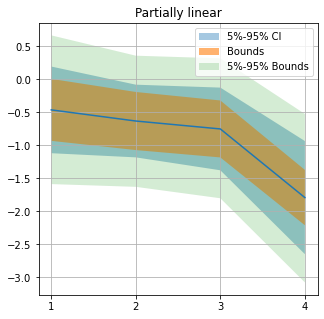

In [50]:
qgr = np.arange(1, 5)

point = [res['dml'].loc[(f'q={q}', 'dml'), 'point'] for q in qgr]
lower = [res['dml'].loc[(f'q={q}', 'dml'), 'point'] - 1.645*res['dml'].loc[(f'q={q}', 'dml'), 'stderr']
         for q in qgr]
upper = [res['dml'].loc[(f'q={q}', 'dml'), 'point'] + 1.645*res['dml'].loc[(f'q={q}', 'dml'), 'stderr']
         for q in qgr]
sens_band = [dml_sensitivity_bounds(ests['dml'][f'q={q}'], .03, .03, alpha=None) for q in qgr]
sens_band_unc = [dml_sensitivity_bounds(ests['dml'][f'q={q}'], .03, .03, alpha=.05) for q in qgr]

# save csv to pass to R
tempdf = pd.DataFrame({"point": point})
tempdf = pd.concat([tempdf, pd.DataFrame(sens_band)], axis = 1)
tempdf = pd.concat([tempdf, pd.DataFrame(sens_band_unc)], axis = 1)
tempdf.to_csv("gas_quart_plm.csv")

plt.figure(figsize=(5, 5))
plt.plot(qgr, point)
plt.fill_between(qgr, lower, upper, alpha=.4, label='5%-95% CI')
plt.fill_between(qgr, *list(zip(*sens_band)), alpha=.6, label='Bounds')
plt.fill_between(qgr, *list(zip(*sens_band_unc)), alpha=.2, label='5%-95% Bounds')
if synthetic:
    plt.plot(qgr, true_moment, label='true')
plt.xticks(qgr)
plt.title('Partially linear')
plt.legend()
plt.grid()
plt.savefig('plinear_quantile_avgder.pdf', dpi=600)

### Based on fitted nuisances on all data as is done in 401k example

In [77]:
X, _, _, _ = get_data(5, synthetic=synthetic, random_seed=123)
inds = np.arange(X.shape[0])
splits = [inds[(X[:, 1] >= math.log(42500) - .5) & (X[:, 1] <= math.log(42500) + .5)],
          inds[(X[:, 1] >= math.log(57500) - .5) & (X[:, 1] <= math.log(57500) + .5)],
          inds[(X[:, 1] >= math.log(72500) - .5) & (X[:, 1] <= math.log(72500) + .5)],
          inds[(X[:, 1] >= 11.6)]]
point, stderr, bounds, cibounds = np.zeros(4), np.zeros(4), np.zeros((4, 2)), np.zeros((4, 2))
qgr = np.arange(4)
for q in qgr:
    points = np.array([np.mean(est.moment_[splits[q]]) for est in ests['rr']['q=5']])
    stderrs = np.array([np.sqrt(np.var(est.moment_[splits[q]])/len(splits[q])) for est in ests['rr']['q=5']])
    point[q] = np.mean(points)
    stderr[q] = np.sqrt(np.mean(stderrs**2) + np.var(points))
    bounds[q, :] = sensitivity_bounds(ests['rr']['q=5'], .04, .03, inds=splits[q])
    cibounds[q, :] = sensitivity_bounds(ests['rr']['q=5'], .04, .03, alpha=0.05, inds=splits[q])

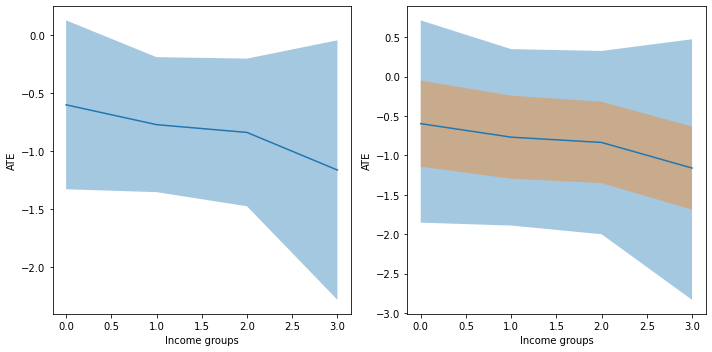

In [79]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.fill_between(qgr, point - 1.645*stderr, point + 1.645*stderr, alpha=.4)
plt.plot(qgr, point)
plt.xlabel("Income groups")
plt.ylabel("ATE")

plt.subplot(1, 2, 2)
plt.fill_between(qgr, cibounds[:, 0], cibounds[:, 1], alpha=.4)
plt.fill_between(qgr, bounds[:, 0], bounds[:, 1], alpha=.4)
plt.plot(qgr, point)
plt.xlabel("Income groups")
plt.ylabel("ATE")
plt.tight_layout()
plt.show()